Files:

nodeId.edges : The edges in the ego network for the node 'nodeId'. Edges are undirected for facebook, and directed (a follows b) for twitter and gplus. The 'ego' node does not appear, but it is assumed that they follow every node id that appears in this file.

nodeId.circles : The set of circles for the ego node. Each line contains one circle, consisting of a series of node ids. The first entry in each line is the name of the circle.

nodeId.feat : The features for each of the nodes that appears in the edge file.

nodeId.egofeat : The features for the ego user.

nodeId.featnames : The names of each of the feature dimensions. Features are '1' if the user has this property in their profile, and '0' otherwise. This file has been anonymized for facebook users, since the names of the features would reveal private data.

### Import Libraries  

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

### Load Data

In [2]:
BASE_PATH = "/kaggle/input/facebook/"
EGO_NODE = "0"  # Focus on the first ego network

### Load edges (friendships)

In [3]:
G = nx.read_edgelist(f"{BASE_PATH}{EGO_NODE}.edges", nodetype=int)
print(f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loaded network with 333 nodes and 2519 edges


### Load circles (user-defined groups)

In [4]:
circles = {}
with open(f"{BASE_PATH}{EGO_NODE}.circles", "r") as f:
    for line in f:
        parts = line.strip().split()
        circle_name = parts[0]
        members = list(map(int, parts[1:]))  # Convert node IDs to integers
        circles[circle_name] = members
print(f"Found {len(circles)} user-defined circles")


Found 24 user-defined circles


### Preprocess Network

In [5]:
# Remove isolated nodes (if any)
initial_nodes = G.number_of_nodes()
G.remove_nodes_from(list(nx.isolates(G)))
print(f"Removed {initial_nodes - G.number_of_nodes()} isolated nodes")

Removed 0 isolated nodes


### Basic Statistics

In [6]:
# Network size
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

# Degree distribution
degrees = [d for _, d in G.degree()]
avg_degree = np.mean(degrees)

# Clustering coefficient
clustering = nx.average_clustering(G)

# Average shortest path length (using largest connected component)
lcc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(lcc)
avg_path_length = nx.average_shortest_path_length(subgraph)

print("\nBasic Statistics:")
print(f"- Nodes: {n_nodes}, Edges: {n_edges}")
print(f"- Avg. degree: {avg_degree:.2f}")
print(f"- Clustering coefficient: {clustering:.3f}")
print(f"- Avg. path length (LCC): {avg_path_length:.2f}")


Basic Statistics:
- Nodes: 333, Edges: 2519
- Avg. degree: 15.13
- Clustering coefficient: 0.508
- Avg. path length (LCC): 3.75


### Null Model (Erdős-Rényi)

In [7]:
n_simulations = 100  # Reduced from 1000 for speed
clustering_er = []
path_length_er = []

# Generate ER networks with same n_nodes and n_edges
p = n_edges / (n_nodes * (n_nodes - 1) / 2)  # Connection probability

for _ in range(n_simulations):
    G_er = nx.erdos_renyi_graph(n_nodes, p)
    
    # Calculate metrics
    clustering_er.append(nx.average_clustering(G_er))
    
    # Handle disconnected ER graphs
    lcc_er = max(nx.connected_components(G_er), key=len)
    if len(lcc_er) > 1:
        subgraph_er = G_er.subgraph(lcc_er)
        path_length_er.append(nx.average_shortest_path_length(subgraph_er))

### Compare Real vs. Null

In [8]:
# Clustering comparison
z_clustering = (clustering - np.mean(clustering_er)) / np.std(clustering_er)

# Path length comparison
z_path = (avg_path_length - np.mean(path_length_er)) / np.std(path_length_er)

print("\nNull Model Comparison:")
print(f"- Clustering z-score: {z_clustering:.2f}")
print(f"- Path length z-score: {z_path:.2f}")


Null Model Comparison:
- Clustering z-score: 204.86
- Path length z-score: 94.84


### Visualizations

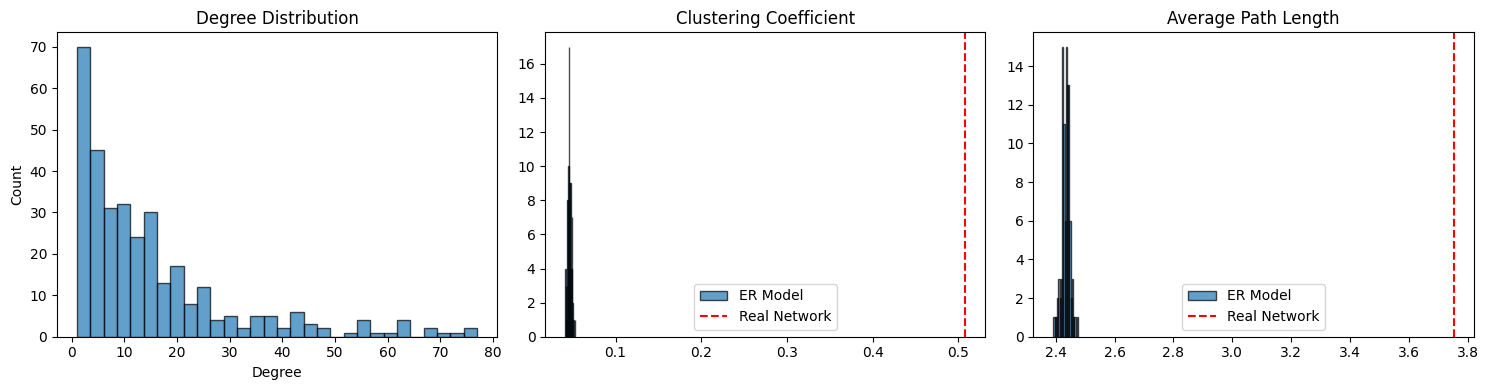

In [9]:
plt.figure(figsize=(15, 4))

# Degree distribution
plt.subplot(131)
plt.hist(degrees, bins=30, edgecolor="k", alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")

# Clustering comparison
plt.subplot(132)
plt.hist(clustering_er, bins=20, edgecolor="k", alpha=0.7, label="ER Model")
plt.axvline(clustering, color="r", linestyle="--", label="Real Network")
plt.title("Clustering Coefficient")
plt.legend()

# Path length comparison
plt.subplot(133)
plt.hist(path_length_er, bins=20, edgecolor="k", alpha=0.7, label="ER Model")
plt.axvline(avg_path_length, color="r", linestyle="--", label="Real Network")
plt.title("Average Path Length")
plt.legend()

plt.tight_layout()
plt.savefig("/kaggle/working/day1_results.png")  # Save to Kaggle output
plt.show()